In [59]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import shutil

In [60]:
projectPath = r"Osteoporosis Knee X-ray"
pathList = []
labelList = []
dirList = os.listdir(projectPath)[:3]
for idx, x in enumerate(dirList):
    for xx in os.listdir(f"{projectPath}/{x}"):
        pathList.append(f"{projectPath}/{x}/{xx}")
        labelList.append(idx)

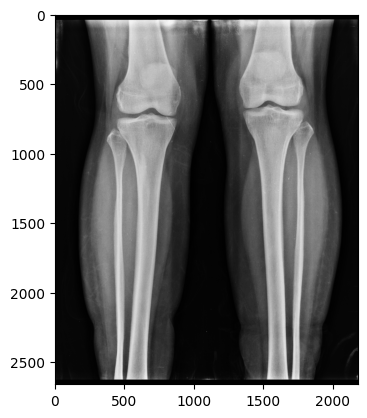

In [61]:
# Read the image
img = cv2.imread(pathList[160])  # Replace 'path/to/image.jpg' with the actual path to your image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

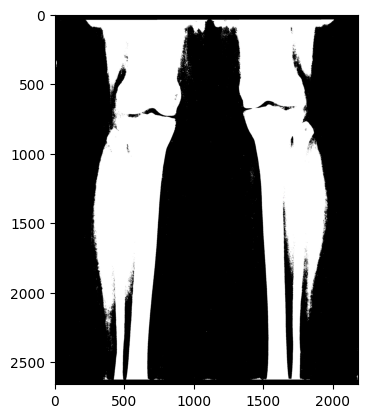

In [62]:

# Apply adaptive thresholding
thresh = cv2.threshold(img,100, 255, cv2.ADAPTIVE_THRESH_MEAN_C)[1]

# Display the thresholded image
plt.imshow(thresh, cmap='gray')

In [63]:
# plt.imshow(apply_threshold(r'Osteoporosis Knee X-ray/normal/N1.JPEG',40, cv2.ADAPTIVE_THRESH_MEAN_C), cmap='gray')

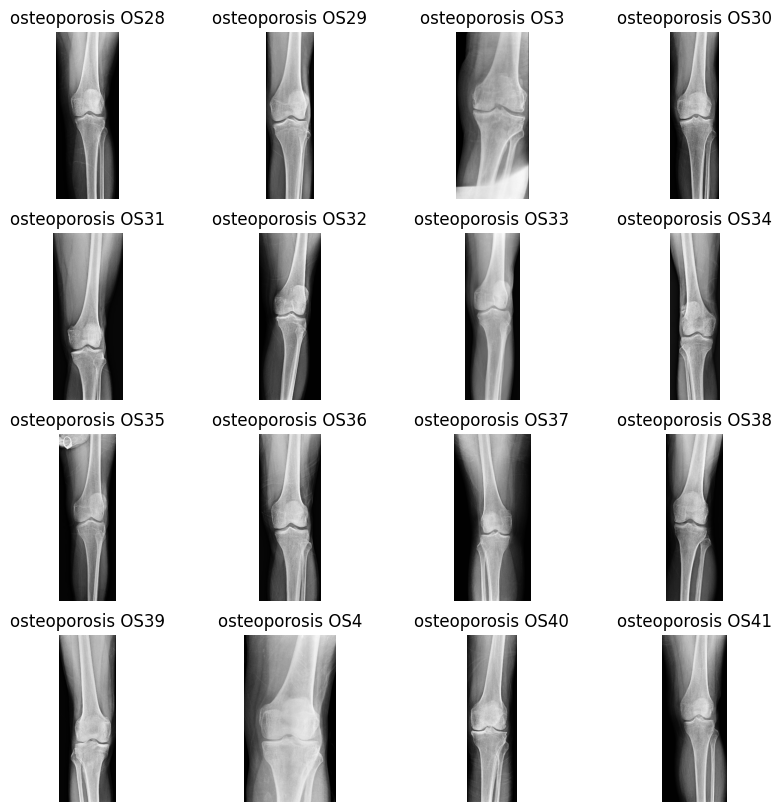

In [64]:
def apply_threshold(image_path,threshFunc):  #function to apply thresholding to an image, returns a list of segmented images
    # Read the image

    originalImage = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    originalImage = cv2.resize(originalImage, (512,512))
    image = cv2.normalize(originalImage, None, alpha= 0, beta=255, norm_type=cv2.NORM_MINMAX, dtype= -1)
    dominant = findDominantColor(image)
    # return image
    # image = cv2.equalizeHist(image)
    # return image
    # Apply a binary threshold
    _, thresholded = cv2.threshold(image, dominant+10, 255, threshFunc)
    thresholded = cv2.erode(thresholded, None, iterations=40)
    thresholded = cv2.dilate(thresholded, None, iterations=40)
    # return thresholded
    boxes = findContour(thresholded)
    segments = []
    for x in boxes:
        x,y,w,h = x
        segments.append(originalImage[y:y+h, x:x+w])
    return segments

def findDominantColor(image):
    # Find the histogram of the image
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    # Find the most frequent color
    color = np.argmax(hist)
    return color

def findContour(image):
    # Find contours
    contours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Draw contours
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(image, contours, -1, (0, 255, 0), 3)

    boxes = []
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        # boxes = image[y:y+h, x:x+w]
        boxes.append((x,y,w,h))
        # cv2.imwrite(f'contour_{i}_{image_path.split("/")[-1]}', roi)
    return boxes

offset = 210 #offsets to watch out in particular: 10,20,150,200,210
# Apply threshold to 16 images
thresholded_images = [apply_threshold(path,cv2.THRESH_TOZERO) for path in pathList[offset:offset+16]]
plt.figure(figsize=(10, 10))
for i, img in enumerate(thresholded_images):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img[0], cmap='gray')
    plt.title(f'{pathList[offset+i].split("/")[1]} {pathList[offset+i].split("/")[2].strip(".jpg").strip(".JPEG")}')
    plt.axis('off')

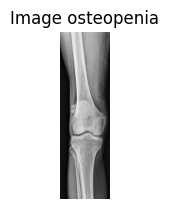

In [89]:
# code to debug the thresholding function/problematic images
# debug = apply_threshold(r"C:\Users\assaw\Documents\c_stuff\Python\machine learning\ISAIConference\Osteoporosis Knee X-ray\osteoporosis\OS34.jpg",cv2.THRESH_TOZERO)
# plt.figure(figsize=(10, 10))
# for i, img in enumerate(debug):
#     plt.subplot(4, 4, i + 1)
#     plt.imshow(img, cmap='gray')
#     plt.title(f'Image {pathList[offset+i].split("/")[1]}')
#     plt.axis('off')

In [66]:
segCount = {}
import shutil
shutil.rmtree('segmentedImages')
os.mkdir("segmentedImages")
os.mkdir("segmentedImages/normal")
os.mkdir("segmentedImages/osteopenia")
os.mkdir("segmentedImages/osteoporosis")

for x in pathList:
    segmentedImages = apply_threshold(x, cv2.THRESH_TOZERO)
    segCount[x.split('/')[-1]] = len(segmentedImages)
    path = f"segmentedImages/{x.split('/')[1]}/{x.split('/')[-1].strip('.JPEG').strip('.jpg')}"
    # os.mkdir(path)
    # cv2.imwrite(f"{path}/original.jpg", cv2.imread(x)) # put this line back if you want to compare the original image too
    for i, img in enumerate(segmentedImages):
        cv2.imwrite(f"{path}{i}.jpg", img)

# Outlier Images are manually dealt with

In [90]:
projectPath = r"segmentedImages"
pathList = []
labelList = []
dirList = os.listdir(projectPath)[:3]
for idx, x in enumerate(dirList):
    for xx in os.listdir(f"{projectPath}/{x}"):
        pathList.append(f"{projectPath}/{x}/{xx}")
        labelList.append(idx)
pathList[:5]

['segmentedImages/normal/N10.jpg',
 'segmentedImages/normal/N100.jpg',
 'segmentedImages/normal/N101.jpg',
 'segmentedImages/normal/N11.jpg',
 'segmentedImages/normal/N110.jpg']

In [88]:
#check if all images are segmented
images = [x.split(r'/')[-1][:-5] for x in pathList]
images
imageCounts = {}
for x in images:
    try:
        imageCounts[str(x)] = imageCounts[str(x)] + 1
    except KeyError:
        imageCounts[str(x)] = 1
imageCounts #varied image sizes, have to resize to 1024,1024]

unique_values = list(set(imageCounts.values()))
unique_counts = [list(imageCounts.values()).count(x) for x in unique_values]
imageCounts = dict(zip(unique_values, unique_counts))
imageCounts

{1: 96, 2: 143}

In [110]:
#transform definition
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
import PIL
class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return F.pad(image, padding, 0, 'constant')

target_image_size = (224, 224)  # as an example
# now use it as the replacement of transforms.Pad class
transform=transforms.Compose([
    SquarePad(),
    transforms.Resize(target_image_size),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [107]:
#apply transforms and save the processed images
dirPath = 'processedImages'
shutil.rmtree(dirPath)
os.mkdir(dirPath)
os.mkdir(dirPath+"/normal")
os.mkdir(dirPath+"/osteopenia")
os.mkdir(dirPath+"/osteoporosis")

for x in pathList:
    image = PIL.Image.open(x).convert('RGB')
    image = transform(image)
    arr = ((image.permute(1,2,0)*255).numpy().astype(np.uint8))
    img = PIL.Image.fromarray(arr,mode="RGB")
    # img.save(x)
    temp = x.split("\\")[-1].replace("segmentedImages",dirPath).split('/')
    # print('/'.join(temp))
    img.save('/'.join(temp))